<a href="https://colab.research.google.com/github/DommiiUdomp/-/blob/main/EuroSatCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EuroSat dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Import the data

In [3]:
import tensorflow_datasets.public_api as tfds

In [4]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [5]:
ds, info = tfds.load('eurosat', with_info=True)

builder = tfds.builder('eurosat')
info = builder.info

In [6]:
info

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

In [7]:
print(info.features.shape)
print(info.features.dtype)
print(info.features['image'].shape)
print(info.features['image'].dtype)
print(info.splits)
print(list(info.splits.keys()))

{'image': (64, 64, 3), 'label': (), 'filename': ()}
{'image': tf.uint8, 'label': tf.int64, 'filename': tf.string}
(64, 64, 3)
<dtype: 'uint8'>
{'train': <tfds.core.SplitInfo num_examples=27000>}
['train']


In [8]:

eu_train, eu_test = tfds.load("eurosat", split=['train', 'train[:20%]'])

assert isinstance(eu_train, tf.data.Dataset)

In [9]:
(img_train, label_train), (img_test, label_test) = tfds.as_numpy(tfds.load(
    'eurosat',
    split=['train', 'train[:20%]'],
    batch_size=-1,
    as_supervised=True,
))

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [11]:
#if download from zip
import zipfile
import io
import requests
from PIL import Image

# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles = [x for x in txtfiles if ".jpg" in x]

In [ ]:
# read images to numpy array
XImages = np.zeros([len(txtfiles), 64, 64, 3])

i = 0
for pic in txtfiles:
  XImages[i] = np.asarray(Image.open(z.open(pic))).astype('uint8')/255
  print(i)
  i += 1

del r # clear memory
del z 

In [13]:
# Get labels in numpy array as strings
Ylabel = np.empty(len(txtfiles), dtype = 'S20')

i = 0
for label in txtfiles:
  Ylabel[i] = label.split('/')[1]
  i += 1

In [14]:
print(XImages.shape)
print(Ylabel.shape)

(27000, 64, 64, 3)
(27000,)


In [15]:
# change them to integers in alphabetical order
label_names, yLabels = np.unique(Ylabel, return_inverse=True)

label_Dict = dict(zip(np.unique(yLabels), label_names))
print(label_Dict)
np.array(np.unique(yLabels, return_counts=True)).T

{0: b'AnnualCrop', 1: b'Forest', 2: b'HerbaceousVegetation', 3: b'Highway', 4: b'Industrial', 5: b'Pasture', 6: b'PermanentCrop', 7: b'Residential', 8: b'River', 9: b'SeaLake'}


array([[   0, 3000],
       [   1, 3000],
       [   2, 3000],
       [   3, 2500],
       [   4, 2500],
       [   5, 2000],
       [   6, 2500],
       [   7, 3000],
       [   8, 2500],
       [   9, 3000]])

1
b'Forest'


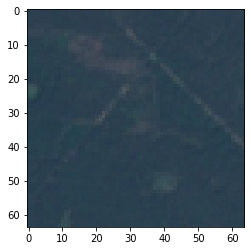

In [16]:
import matplotlib.pyplot as plt

# test the labels and images 
tmp = 20000
img = XImages[tmp]

print(yLabels[tmp])
print(label_names[yLabels[tmp]])
plt.imshow(img);

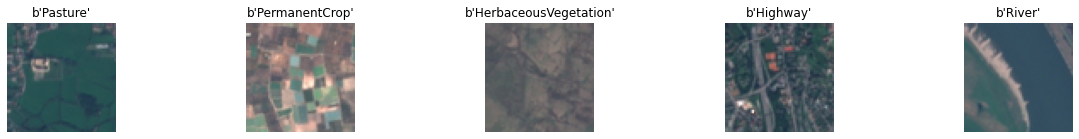

In [21]:
#Select a random sample of images and Plot
import matplotlib.pyplot as plt

num_test_images = XImages.shape[0]
random_inx = np.random.choice(num_test_images, 5)
random_test_images = XImages[random_inx, ...]
random_test_labels = Ylabel[random_inx, ...]

fig, ax = plt.subplots(1, 5, figsize =(20, 2) )
fig.subplots_adjust(hspace=0.2, wspace=0.5)
for i in range (5) :
  ax[i].set_axis_off()
  ax[i].set_title(random_test_labels[i])
  ax[i].imshow(random_test_images[i])

In [22]:
# find the smallest class
smallest_class = np.argmin(np.bincount(yLabels))
smallest_class

5

In [23]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

# number of classes
num_classes = len(np.array(np.unique(yLabels)))
# observations in smallest class
smallest_class_obs = np.where(yLabels == smallest_class)[0]
print(smallest_class_obs.shape)

(2000,)


In [24]:
shuffle(np.where(yLabels == i)[0], random_state=42).shape

(2500,)

In [25]:
shuffle(np.where(yLabels == i)[0], random_state=42)[0:smallest_class_obs.shape[0]].shape

(2000,)

In [26]:
# Get 2000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp = shuffle(np.where(yLabels == i)[0], random_state=42)[0:smallest_class_obs.shape[0]]
  indBal = np.concatenate([indBal, indTemp])

# shuffle the balanced index
indBal = shuffle(indBal, random_state = 42)

In [27]:
indBal.shape

(20000,)

In [36]:
from sklearn.model_selection import train_test_split
#Unbalanced labels
X_train, X_test, y_train, y_test = train_test_split(XImages, yLabels, stratify = yLabels, train_size = 0.5, random_state=42)

b'Industrial'


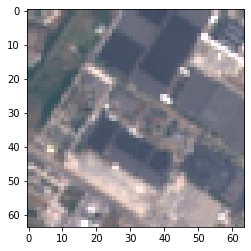

In [37]:
# test that the labels and images 
tmp = 5000
img = X_train[tmp]

print(label_names[y_train[tmp]])
plt.imshow(img); 

In [38]:
yBal = yLabels[indBal]
XBal = XImages[indBal]

print(yBal.shape)
print(XBal.shape)

(20000,)
(20000, 64, 64, 3)


In [39]:
#balanced labels
X_train, X_test, y_train, y_test = train_test_split(XBal, yBal, stratify = yBal, train_size = 0.5, random_state=42)

b'AnnualCrop'


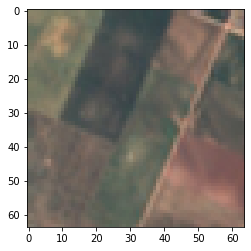

In [40]:
# test that the labels and images 
tmp = 5000
img = X_train[tmp]

print(label_names[y_train[tmp]])
plt.imshow(img);

In [41]:
from tensorflow.keras.utils import to_categorical

# class distribution for yTrain
np.array(np.unique(y_train, return_counts=True)).T

# class distribution for yTest
np.array(np.unique(y_test, return_counts=True)).T

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10000, 64, 64, 3)
(10000, 64, 64, 3)
(10000, 10)
(10000, 10)


In [46]:
# Convert train and test images into 'float64' type

# train_images = train_images.astype('float64')
# test_images = test_images.astype('float64')

# Convert train and test labels into 'int64' type

y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

In [104]:
# Initialize grayscale arrays
X_train_BW = np.zeros([X_train.shape[0],
                       X_train.shape[1],
                       X_train.shape[2]])

X_test_BW = np.zeros([X_test.shape[0],
                      X_test.shape[1],
                      X_test.shape[2]])
print(X_train_BW.shape)
print(X_test_BW.shape)

(10000, 64, 64)
(10000, 64, 64)


In [106]:
#or
X_train_BW = np.average(X_train, axis=-1)
X_test_BW = np.average(X_test, axis=-1)
print(X_train_BW.shape)
print(X_test_BW.shape)

(10000, 64, 64)
(10000, 64, 64)


[b'Forest' b'AnnualCrop' b'AnnualCrop' b'AnnualCrop' b'AnnualCrop'
 b'AnnualCrop' b'AnnualCrop' b'AnnualCrop' b'AnnualCrop' b'AnnualCrop']


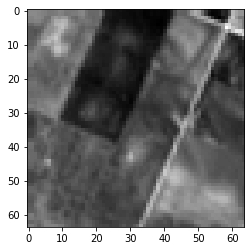

In [64]:
# test that the labels and images 
tmp = 5000
img = X_train_BW[tmp]

print(label_names[y_train[tmp]])
plt.imshow(img, interpolation='nearest', cmap=plt.get_cmap('gray') )

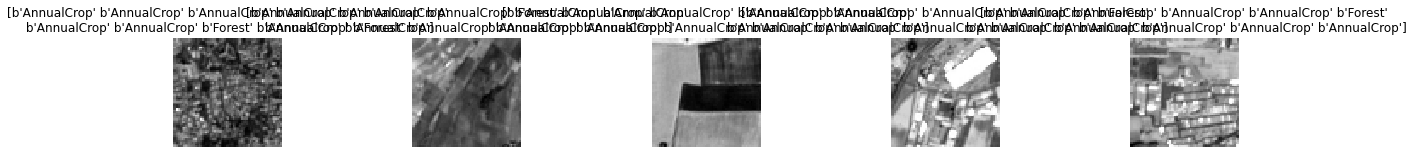

In [57]:
#Select a random sample of images and Plot
num_test_images = X_train_BW.shape[0]
random_inx = np.random.choice(num_test_images, 5)
random_test_images = X_train_BW[random_inx, ...]
random_test_labels = label_names[y_train[random_inx, ...]]

fig, ax = plt.subplots(1, 5, figsize =(20, 2) )
fig.subplots_adjust(hspace=0.2, wspace=0.5)
for i in range (5) :
  ax[i].set_axis_off()
  ax[i].set_title(f'{random_test_labels[i]}')
  ax[i].imshow(random_test_images[i],interpolation='nearest', cmap=plt.get_cmap('gray'))

In [108]:
from skimage.color import rgb2gray

# convert RGB arrays to grayscale
for i in range(X_train.shape[0]):
  X_train_BW[i] = rgb2gray(X_train[i])
  X_test_BW[i] = rgb2gray(X_test[i])

# flatten grayscale arrays
X_train_BW = X_train_BW.reshape(X_train_BW.shape[0],
                                X_train_BW.shape[1] * X_train_BW.shape[2])

X_test_BW = X_test_BW.reshape(X_test_BW.shape[0],
                              X_test_BW.shape[1] * X_test_BW.shape[2])

print(X_train_BW.shape)
print(X_test_BW.shape)
print(y_train.shape)
print(y_test.shape)

(10000, 4096)
(10000, 4096)
(10000, 10)
(10000, 10)


In [65]:
# Add a dummy channel dimension

my_image_train = X_train_BW[..., np.newaxis]
my_image_test = X_test_BW[..., np.newaxis]

from sklearn.preprocessing import LabelBinarizer


# One-hot encoding of train and test labels

# Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. 
# Hint: retain the channel dimension, which will now have size 1.
lb = LabelBinarizer()
my_train_labels = lb.fit_transform(y_train)
my_test_labels = lb.fit_transform(y_test)

print(my_train_labels.shape)
print(my_test_labels.shape)
print(my_image_train.shape)
print (my_image_test.shape)

(10000, 10)
(10000, 10)
(10000, 64, 64, 1)
(10000, 64, 64, 1)


In [111]:
X_train_BW[0].shape

(4096,)

In [68]:
my_image_train[0].shape

(64, 64, 1)

#Build the model

In [145]:
def model_1(input_shape) :
  model_1 = Sequential()
  model_1.add(Dense(num_classes, activation='softmax', input_shape=(input_shape)))
  model_1.add(Dense(10, activation = 'softmax'))
  
  model_1.compile (optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001) ,
                 loss = tf.keras.losses.CategoricalCrossentropy(), 
                 metrics = [tf.keras.metrics.Accuracy()])
    
  return model_1

In [146]:
model_1 = model_1(X_train_BW[0].shape)
model_1.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 10)                40970     
_________________________________________________________________
dense_43 (Dense)             (None, 10)                110       
Total params: 41,080
Trainable params: 41,080
Non-trainable params: 0
_________________________________________________________________


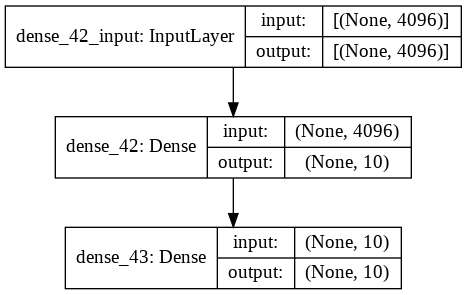

In [147]:
from keras.utils.vis_utils import plot_model
plot_model(model_1, show_shapes=True, show_layer_names=True)

In [148]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint (filepath = 'checkpoint/checkpoint', monitor = 'val_loss',
                              save_weights_only = True,save_beat_only = True, save_freq = 'epoch', verbose = 1)

early = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'max', min_delta = 5, verbose = 1 )

call = [checkpoint, early]

In [149]:
history = model_1.fit(X_train_BW,y_train, validation_data= (X_test_BW, y_test) , batch_size=64, epochs=100, callbacks=call, verbose=1)

Epoch 1/100
157/157 [==============================] - 1s 6ms/step - loss: 2.2981 - accuracy: 0.0000e+00 - val_loss: 2.2942 - val_accuracy: 0.0000e+00

Epoch 00001: saving model to checkpoint/checkpoint
Epoch 2/100
157/157 [==============================] - 1s 4ms/step - loss: 2.2929 - accuracy: 0.0000e+00 - val_loss: 2.2923 - val_accuracy: 0.0000e+00

Epoch 00002: saving model to checkpoint/checkpoint
Epoch 3/100
157/157 [==============================] - 1s 5ms/step - loss: 2.2903 - accuracy: 0.0000e+00 - val_loss: 2.2896 - val_accuracy: 0.0000e+00

Epoch 00003: saving model to checkpoint/checkpoint
Epoch 4/100
157/157 [==============================] - 1s 5ms/step - loss: 2.2868 - accuracy: 0.0000e+00 - val_loss: 2.2867 - val_accuracy: 0.0000e+00

Epoch 00004: saving model to checkpoint/checkpoint
Epoch 5/100
157/157 [==============================] - 1s 5ms/step - loss: 2.2840 - accuracy: 0.0000e+00 - val_loss: 2.2832 - val_accuracy: 0.0000e+00

Epoch 00005: saving model to checkpo

In [150]:
score = model_1.evaluate(X_test_BW, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 0s 1ms/step - loss: 2.2703 - accuracy: 0.0000e+00
Test loss: 2.2702689170837402
Test accuracy: 0.0


In [151]:
import pandas as pd
frame = pd.DataFrame(history.history)
frame.head()

,loss,accuracy,val_loss,val_accuracy
0,2.298113,0.0,2.294220,0.0
1,2.292866,0.0,2.292320,0.0
2,2.290257,0.0,2.289616,0.0
3,2.286759,0.0,2.286669,0.0
4,2.284014,0.0,2.283196,0.0


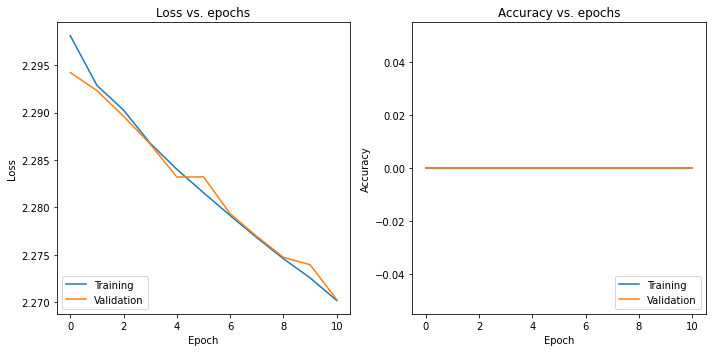

In [152]:

# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

In [153]:
y_test_true_tmp = np.argmax(y_test, axis = 1)
label_count = np.unique(y_test_true_tmp, return_counts = True)[1]

In [156]:
# Define functions for evaluating model accuracy by class and overall

def eval_model_by_class(model, test_set):
  y_test_pred = model.predict(test_set)
  y_test_pred_tmp=np.argmax(y_test_pred,axis=1)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()
  pred_df['label_count'] = label_count
  pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
  pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
  pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
  pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

  return(pred_df)

def find_wrong_preds(model, test_set):
  y_test_pred = model.predict(test_set)
  y_test_pred_tmp=np.argmax(y_test_pred,axis=1)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  # pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
  pred_df = pred_df.sort_values('y_true')

  return(pred_df)

In [157]:
M1_pred_df = eval_model_by_class(model_1, X_test_BW)
M1_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',0,1000,0.000,0.1776
1,1,b'Forest',1000,1000,1.000,0.1776
2,2,b'HerbaceousVegetation',534,1000,0.534,0.1776
3,3,b'Highway',17,1000,0.017,0.1776
4,4,b'Industrial',21,1000,0.021,0.1776
5,5,b'Pasture',0,1000,0.000,0.1776
6,6,b'PermanentCrop',0,1000,0.000,0.1776
7,7,b'Residential',0,1000,0.000,0.1776
8,8,b'River',204,1000,0.204,0.1776
9,9,b'SeaLake',0,1000,0.000,0.1776


#new model

In [ ]:
from tensorflow.keras
K.set_image_dim_ordering('th')

In [174]:
def model(input_shape, weight_decay) :
  model = Sequential()
  model.add (Conv2D (16, (5,5), activation = 'relu', padding = 'same', name = 'conv_1', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(weight_decay), input_shape = input_shape))
  model.add (Conv2D (16, (5,5), activation = 'relu', padding = 'same', name = 'conv_2', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(weight_decay)))
  model.add (MaxPooling2D ((4,4) , strides=(2,2), name = 'pool_1'))
  model.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_3', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(weight_decay)))
  model.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_4', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(weight_decay)))
  model.add (MaxPooling2D ((4,4) , strides=(2,2),name = 'pool_2'))
  model.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_5', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(weight_decay)))
  model.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_6', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(weight_decay)))
  model.add (MaxPooling2D ((4,4) , strides=(2,2),name = 'pool_3'))
  model.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_7', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(weight_decay)))
  model.add (Conv2D (16, (3,3), activation = 'relu', padding = 'same', name = 'conv_8', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(weight_decay)))
  model.add (MaxPooling2D ((4,4) , strides=(2,2),name = 'pool_4'))
  model.add (Flatten ())
  model.add (Dense (num_classes, activation = 'relu', kernel_initializer='he_uniform',bias_initializer="ones", 
                             kernel_regularizer=tf.keras.regularizers.l1(weight_decay) , name = 'dense_1') )
  model.add (Dense (10, activation = 'softmax', name = 'dense_2') )
  
  model.compile (optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001) ,
                 loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
                 metrics = ['accuracy'])
  
  return model

In [175]:
model = model(my_image_train[0].shape, 1e-8)
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 64, 16)        416       
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 64, 16)        6416      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 31, 31, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 31, 31, 16)        2320      
_________________________________________________________________
conv_4 (Conv2D)              (None, 31, 31, 16)        2320      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 14, 14, 16)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 14, 14, 16)      

In [176]:
history_1 = model.fit(my_image_train,my_train_labels, validation_data= (my_image_test, my_test_labels) , batch_size=64, epochs=100, callbacks=call, verbose=1)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


157/157 [==============================] - 195s 928ms/step - loss: 3.7342 - accuracy: 0.1130 - val_loss: 2.2909 - val_accuracy: 0.1592

Epoch 00001: saving model to checkpoint/checkpoint
Epoch 2/100
157/157 [==============================] - 146s 929ms/step - loss: 2.1895 - accuracy: 0.2384 - val_loss: 2.1157 - val_accuracy: 0.3103

Epoch 00002: saving model to checkpoint/checkpoint
Epoch 3/100
157/157 [==============================] - 146s 931ms/step - loss: 2.1074 - accuracy: 0.2787 - val_loss: 2.1269 - val_accuracy: 0.2642

Epoch 00003: saving model to checkpoint/checkpoint
Epoch 4/100
157/157 [==============================] - 146s 930ms/step - loss: 2.0340 - accuracy: 0.3084 - val_loss: 1.9729 - val_accuracy: 0.3377

Epoch 00004: saving model to checkpoint/checkpoint
Epoch 5/100
157/157 [==============================] - 146s 931ms/step - loss: 1.9771 - accuracy: 0.3246 - val_loss: 1.8975 - val_accuracy: 0.3490

Epoch 00005: saving model to checkpoint/checkpoint
Epoch 6/100
157/1

In [177]:
score = model.evaluate(my_image_test, my_test_labels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 27s 85ms/step - loss: 1.8875 - accuracy: 0.3127
Test loss: 1.8874903917312622
Test accuracy: 0.3127000033855438


In [178]:
import pandas as pd
frame_1 = pd.DataFrame(history_1.history)
frame_1.head()

,loss,accuracy,val_loss,val_accuracy
0,3.734194,0.1130,2.290874,0.1592
1,2.189451,0.2384,2.115696,0.3103
2,2.107380,0.2787,2.126892,0.2642
3,2.034050,0.3084,1.972877,0.3377
4,1.977079,0.3246,1.897531,0.3490


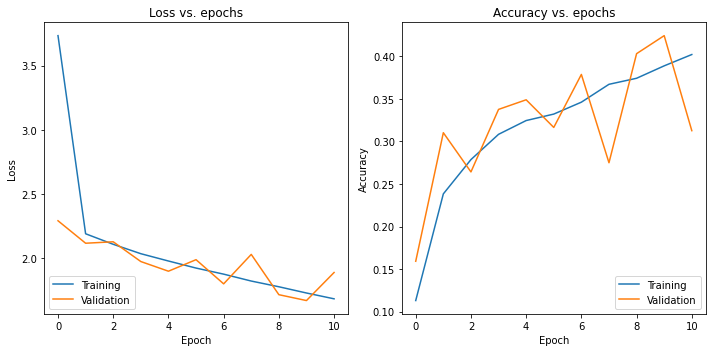

In [180]:
# Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower left')
ax2 = plt.subplot(122)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training','Validation'],loc='lower right')
plt.tight_layout()
plt.show()

In [181]:
M1_pred_df_1 = eval_model_by_class(model, my_image_test)
M1_pred_df_1

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',88,1000,0.088,0.3127
1,1,b'Forest',959,1000,0.959,0.3127
2,2,b'HerbaceousVegetation',604,1000,0.604,0.3127
3,3,b'Highway',149,1000,0.149,0.3127
4,4,b'Industrial',581,1000,0.581,0.3127
5,5,b'Pasture',3,1000,0.003,0.3127
6,6,b'PermanentCrop',199,1000,0.199,0.3127
7,7,b'Residential',135,1000,0.135,0.3127
8,8,b'River',409,1000,0.409,0.3127
9,9,b'SeaLake',0,1000,0.000,0.3127
